In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 9 2024

@author: Yaning
Suggested by Sascha
"""

import math
import os
# from turtle import position
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform, Gamma
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean 
import pandas as pd

/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_316953/3269228629.py:22: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
class Agent:
    def __init__(self, ds_rate, variance):
        # free parameters (the mean and variant of the estimate value)
        self.ds_rate = ds_rate
        self.variance = variance


    def estimation(self, curr_LL, curr_delay, curr_SS):
        # the estimate value is assumed to be a normal distribution
        # the estimate value mean is assumed to LL/1+kt
        # the estimate value variant is set to be 4
        self.LL_es_mu = curr_LL/(1+self.ds_rate*curr_delay)
        self.LL_es_sigma = self.variance
        # the fixed early and small value
        self.curr_SS = curr_SS


    def generate_action(self):
        # 1 means choosing large later
        # pyro distribution is used (i guess it is the same as torch's distribution)
        # somehow using binomial or bernoulli is a bit slower to generate the data
        # maybe because there are two distributions? 
        LL_distri = Normal(loc = torch.tensor(self.LL_es_mu), scale =torch.tensor(self.LL_es_sigma))
        chose_LL_pobs = 1 - LL_distri.cdf(torch.tensor(self.curr_SS))
        LL_bino = Binomial(probs = chose_LL_pobs)
        return LL_bino.sample().item()

In [3]:
# discounting rate is 1/16
# estimation variance 4

disc_rate = 1/16
var_es = 4

agent = Agent(disc_rate, var_es)

# initialise trial combinations
repetition = 10
delays = [1, 3, 7, 13, 24, 32, 45, 58, 75, 122]
SS_values = [5]
# values by percentage
LL_values_p = [1.05, 1.055, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.85, 1.9, 2.05, 2.25, 2.55, 2.85, 3.05, 3.45, 3.85]

# create some empty arrays
# get rid of the same ss, ll and delay repitition only percentage
a_percentage = []
a_ss_values = []
a_ll_values = []
a_delays = []

# future tensor for inference specifically
inference_ss_values = []
inference_ll_values = []
inference_delays = []
inference_actions = []

# simulation
for i in SS_values:
    for j in LL_values_p:
        for k in delays:
            one_combination_actions = []
            temp_ll_value = i*j
            a_ll_values.append(temp_ll_value)
            a_delays.append(k)
            a_ss_values.append(i)
            for r in range(repetition):
                agent.estimation(temp_ll_value, k, i)
                action = agent.generate_action()
                one_combination_actions.append(action)
                inference_ss_values.append(i)
                inference_ll_values.append(temp_ll_value)
                inference_delays.append(k)
                inference_actions.append(action)
            a_percentage.append(len(list(filter(lambda x: (x == 1), one_combination_actions))) 
                                      / len(one_combination_actions))

print(a_percentage)

[0.5, 0.5, 0.4, 0.3, 0.0, 0.2, 0.1, 0.2, 0.2, 0.1, 0.4, 0.2, 0.1, 0.2, 0.1, 0.1, 0.1, 0.2, 0.1, 0.2, 1.0, 0.7, 0.3, 0.2, 0.5, 0.0, 0.4, 0.0, 0.3, 0.1, 0.6, 0.7, 0.7, 0.2, 0.1, 0.3, 0.2, 0.0, 0.2, 0.2, 0.7, 0.6, 0.5, 0.4, 0.4, 0.2, 0.0, 0.2, 0.1, 0.5, 0.3, 0.4, 0.3, 0.4, 0.4, 0.1, 0.3, 0.3, 0.4, 0.1, 0.5, 0.6, 0.4, 0.4, 0.2, 0.5, 0.3, 0.2, 0.3, 0.0, 0.8, 0.6, 0.8, 0.2, 0.4, 0.1, 0.3, 0.2, 0.0, 0.1, 0.5, 0.9, 0.5, 0.6, 0.4, 0.2, 0.3, 0.4, 0.0, 0.3, 0.9, 0.7, 0.7, 0.7, 0.5, 0.1, 0.1, 0.1, 0.3, 0.1, 0.9, 0.7, 0.6, 0.7, 0.5, 0.7, 0.1, 0.3, 0.6, 0.1, 0.9, 0.8, 0.7, 0.8, 0.6, 0.4, 0.6, 0.4, 0.0, 0.3, 0.9, 0.9, 0.9, 0.6, 0.5, 0.4, 0.5, 0.4, 0.3, 0.1, 1.0, 0.9, 0.9, 0.8, 0.4, 0.4, 0.3, 0.5, 0.5, 0.0, 1.0, 1.0, 0.9, 0.9, 0.7, 0.5, 0.6, 0.3, 0.1, 0.3, 1.0, 1.0, 1.0, 0.7, 0.6, 0.5, 0.4, 0.5, 0.1, 0.2, 1.0, 1.0, 0.9, 1.0, 0.6, 0.8, 0.3, 0.2, 0.4, 0.2]


In [7]:
actions[3]

tensor(1.)

In [5]:

actions = torch.tensor(inference_actions)
delays = torch.tensor(inference_delays)
ss_values = torch.tensor(inference_ss_values)
ll_values = torch.tensor(inference_ll_values)
# print(actions)
# print(delays)
# print(ss_values)
# print(ll_values)

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
# the step was 2000
n_steps = 2 if smoke_test else 200

# assert pyro.__version__.startswith('1.8.6')

# clear the param store in case we're in a REPL
pyro.clear_param_store()

def model(actions, delays, ss_values, ll_values):
    # define the hyperparameters that control the Beta prior
    dev_alpha_ini = torch.tensor(2.0)
    dev_beta_ini = torch.tensor(1.)
    rate_alpha_ini =torch.tensor(1.)
    rate_beta_ini = torch.tensor(2.)
    # dev_alpha_ini = pyro.param("dev_alpha_ini", torch.tensor(2.0), 
    #                            constraint=constraints.positive)
    # dev_beta_ini = pyro.param("dev_beta_ini", torch.tensor(1.0), 
    #                            constraint=constraints.positive)
    # rate_alpha_ini = pyro.param("rate_alpha_ini", torch.tensor(1.0), 
    #                            constraint=constraints.positive)
    # rate_beta_ini = pyro.param("rate_beta_ini", torch.tensor(2.0), 
    #                            constraint=constraints.positive)
    # sample dev and rate both from the Gamma prior
    dev = pyro.sample("dev", Gamma(dev_alpha_ini, dev_beta_ini))
    rate = pyro.sample("rate", Gamma(rate_alpha_ini, rate_beta_ini))
    # loop over the observed data
    for i in range(len(actions)):
        mean = ll_values[i]/(1+rate*delays[i])
        distri = Normal(loc = mean, scale = dev)
        pos = 1 - distri.cdf(ss_values[i])
        pyro.sample("obs_" + str(i), Binomial(probs = pos), obs=actions[i])

def guide(actions, delays, ss_values, ll_values):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    dev_alpha_q = pyro.param("dev_alpha_q", torch.tensor(2.0),
                         constraint=constraints.positive)
    dev_beta_q = pyro.param("dev_beta_q", torch.tensor(1.0),
                         constraint=constraints.positive)
    rate_alpha_q = pyro.param("rate_alpha_q", torch.tensor(1.0),
                         constraint=constraints.positive)
    rate_beta_q = pyro.param("rate_beta_q", torch.tensor(2.0),
                         constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("dev", Gamma(dev_alpha_q, dev_beta_q))
    pyro.sample("rate", Gamma(rate_alpha_q, rate_beta_q))

auto_g = pyro.infer.autoguide.AutoMultivariateNormal(model)

# pyro.render_model(model=model, model_args=(actions, delays, ss_values, ll_values,),
#                   render_params=True, render_distributions=True,filename="model.pdf")
# pyro.render_model(guide, model_args=(actions, delays, ss_values, ll_values), render_params=True, render_distributions=True)

Mean ELBO 931.43: 100%|███████████████████████████████████████████| 200/200 [03:15<00:00,  1.02it/s]


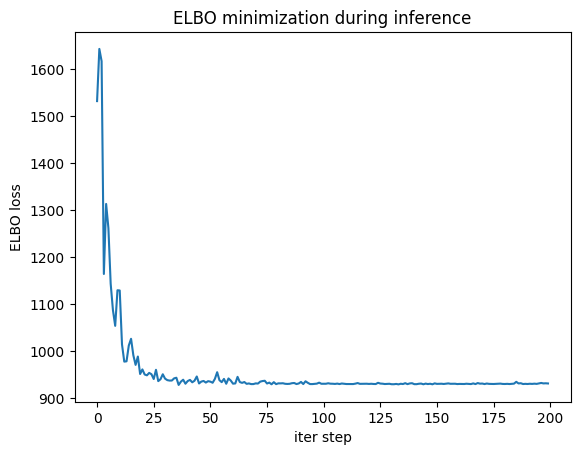

In [6]:
# setup the optimizer
# the learning rate was 0.0005
adam_params = {"lr": 0.05, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)


# setup the inference algorithm
svi = SVI(model, auto_g, optimizer, loss=Trace_ELBO())
# svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

loss = []
pbar = tqdm(range(n_steps), position = 0)
# do gradient steps
for step in pbar:
    loss.append(torch.tensor(svi.step(actions, delays, ss_values, ll_values)))
    pbar.set_description("Mean ELBO %6.2f" % torch.tensor(loss[-20:]).mean())
    if torch.isnan(loss[-1]):
	    break

plt.figure()
plt.plot(loss)
plt.xlabel("iter step")
plt.ylabel("ELBO loss")
plt.title("ELBO minimization during inference")
plt.show()

# grab the learned variational parameters
# alpha_q = pyro.param("alpha_q").item()
# beta_q = pyro.param("beta_q").item()

# # here we use some facts about the Beta distribution
# # compute the inferred mean of the coin's fairness
# inferred_mean = alpha_q / (alpha_q + beta_q)
# # compute inferred standard deviation
# factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
# inferred_std = inferred_mean * math.sqrt(factor)

# print("\nBased on the data and our prior belief, the fairness " +
#       "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

Get the posterior: first the kl distance between posterior and prior

In [30]:
ran_auto_guide = auto_g()

[array(4.1795154, dtype=float32), array(3.8000395, dtype=float32), array(3.964579, dtype=float32), array(3.874678, dtype=float32), array(4.06464, dtype=float32), array(4.2040906, dtype=float32), array(3.7167745, dtype=float32), array(3.902023, dtype=float32), array(4.0568314, dtype=float32), array(3.9727116, dtype=float32), array(3.8047965, dtype=float32), array(4.1654706, dtype=float32), array(3.6065726, dtype=float32), array(4.450125, dtype=float32), array(4.005277, dtype=float32), array(3.7415032, dtype=float32), array(3.6199067, dtype=float32), array(3.3684978, dtype=float32), array(3.6792567, dtype=float32), array(4.6411133, dtype=float32), array(3.4508169, dtype=float32), array(4.0425835, dtype=float32), array(3.7286081, dtype=float32), array(3.4146543, dtype=float32), array(4.017679, dtype=float32), array(3.4330406, dtype=float32), array(3.8093565, dtype=float32), array(3.9073267, dtype=float32), array(4.0435286, dtype=float32), array(3.9474528, dtype=float32), array(4.1663036, 

(array([1., 0., 1., 1., 0., 1., 2., 1., 1., 1., 1., 1., 3., 2., 3., 0., 5.,
        6., 4., 4., 5., 3., 4., 5., 6., 5., 4., 3., 2., 2., 0., 1., 2., 3.,
        2., 3., 1., 4., 0., 0., 2., 2., 0., 2., 0., 0., 0., 0., 0., 1.]),
 array([0.04508269, 0.045509  , 0.04593532, 0.04636164, 0.04678795,
        0.04721427, 0.04764058, 0.0480669 , 0.04849322, 0.04891953,
        0.04934585, 0.04977217, 0.05019848, 0.0506248 , 0.05105111,
        0.05147743, 0.05190375, 0.05233006, 0.05275638, 0.0531827 ,
        0.05360901, 0.05403533, 0.05446164, 0.05488796, 0.05531428,
        0.05574059, 0.05616691, 0.05659322, 0.05701954, 0.05744585,
        0.05787217, 0.05829849, 0.05872481, 0.05915112, 0.05957744,
        0.06000375, 0.06043007, 0.06085638, 0.0612827 , 0.06170902,
        0.06213533, 0.06256165, 0.06298797, 0.06341428, 0.0638406 ,
        0.06426691, 0.06469323, 0.06511954, 0.06554586, 0.06597218,
        0.06639849]),
 <BarContainer object of 50 artists>)

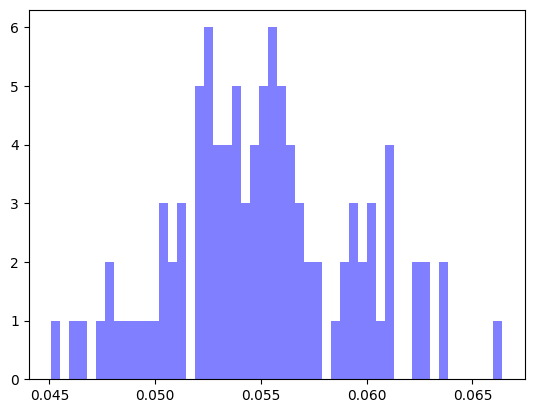

In [16]:
auto_g()
n_samples = 100
post_dev = []
post_rate = []

for i in range(n_samples):
    sample = auto_g()
    post_dev.append(sample["dev"].detach().numpy())
    post_rate.append(sample["rate"].detach().numpy())


print(post_dev)
print(post_rate)

# plt.hist(post_dev, 50, facecolor='green', alpha=0.5)

plt.hist(post_rate, 50, facecolor='blue', alpha=0.5)

In [9]:

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))